In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.fft import rfft, rfftfreq 
from scipy import signal
from scipy.fft import fftshift 

In [24]:
#df = pd.read_csv("C:/Users/JackC/Documents/TU Delft/BAP/Measurements/Blinking.csv", sep=",")
#df = pd.read_csv("C:/Users/JackC/Documents/TU Delft/BAP/Measurements/Physcial clincing right forearm.csv", sep=",")
df = pd.read_csv("C:/Users/JackC/Documents/GitHub/EEGcontroller/MeasurementSubgroup/Our_measurements/Measurement_prompt/EEGdata-2024-156--15-27-22.csv", sep=",")
#df = pd.read_csv("C:/Users/JackC/Documents/GitHub/EEGcontroller/MeasurementSubgroup/Our_measurements/Measurement_prompt_labels/Label_2024-144--15-54-35_1.csv", sep=",")
#df = pd.read_csv("C:/Users/JackC/Documents/GitHub/EEGcontroller/MeasurementSubgroup/Our_measurements/Measurement_Test/Label0Test.csv", sep=",")
#df = pd.read_csv('C:/Users/JackC/Documents/GitHub/EEGcontroller/MeasurementSubgroup/Our_measurements/Measurement_prompt_ICA/EEGdata-2024-144--15-54-35_ICA.csv', sep = ",")
end = df.shape[0] - 5
fs = 250
df = df.iloc[:end, :8] # 3000 samples is 12 seconds of data
df

,FZ,C3,CZ,C4,PZ,PO7,OZ,PO8
0,219555.031250,241335.734375,234679.734375,226841.343750,215790.546875,234374.406250,196353.828125,223851.296875
1,219596.421875,241464.468750,235045.859375,226900.078125,216102.671875,234530.515625,196564.468750,224010.359375
2,219636.484375,241585.625000,235466.515625,226963.203125,216477.015625,234769.859375,196850.484375,224211.156250
3,219598.843750,241540.468750,235335.187500,226933.421875,216371.515625,234736.953125,196792.718750,224152.515625
4,219532.859375,241369.437500,234843.171875,226841.703125,215943.875000,234487.953125,196481.046875,223921.390625
...,...,...,...,...,...,...,...,...
71995,218489.031250,240626.906250,233576.546875,224733.750000,215304.796875,233494.656250,195442.593750,223645.578125
71996,218556.265625,240772.640625,233993.812500,224823.515625,215672.265625,233709.218750,195692.578125,223843.703125
71997,218576.203125,240910.953125,234384.343750,224856.421875,216017.640625,233940.796875,195945.062500,224012.140625
71998,218540.437500,240854.187500,234215.812500,224816.890625,215871.453125,233881.781250,195864.859375,223933.015625


In [25]:
# Define the segment size
prompt_size = 1500
prompts = end/prompt_size

for i in range(int(prompts)):
    df.iloc[1500*i : 1500*(i+1)] = signal.detrend(df.iloc[1500*i : 1500*(i+1)], axis = 0)

df_filt_detr = np.array(df)

In [26]:
from scipy.signal import butter, lfilter, lfilter_zi
from scipy import signal

# Define the filter parameters
lowcut = 6
highcut = 30
fs = 250  # Sampling frequency

# Calculate the filter coefficients
nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(8, [low, high], btype='band')

# Apply the filter to each column of the DataFrame
df_filt = lfilter(b, a, df_filt_detr, axis = 0)

# import scipy.signal as signal

# Define the notch filter parameters
fs = 250  # Sampling frequency
f0 = 50  # Notch frequency
Q = 1 # Quality factor

# Design the notch filter
b, a = signal.iirnotch(f0, Q, fs)

# Apply the filter to each column of the DataFrame
df_filt1 = lfilter(b, a, df_filt, axis = 0)

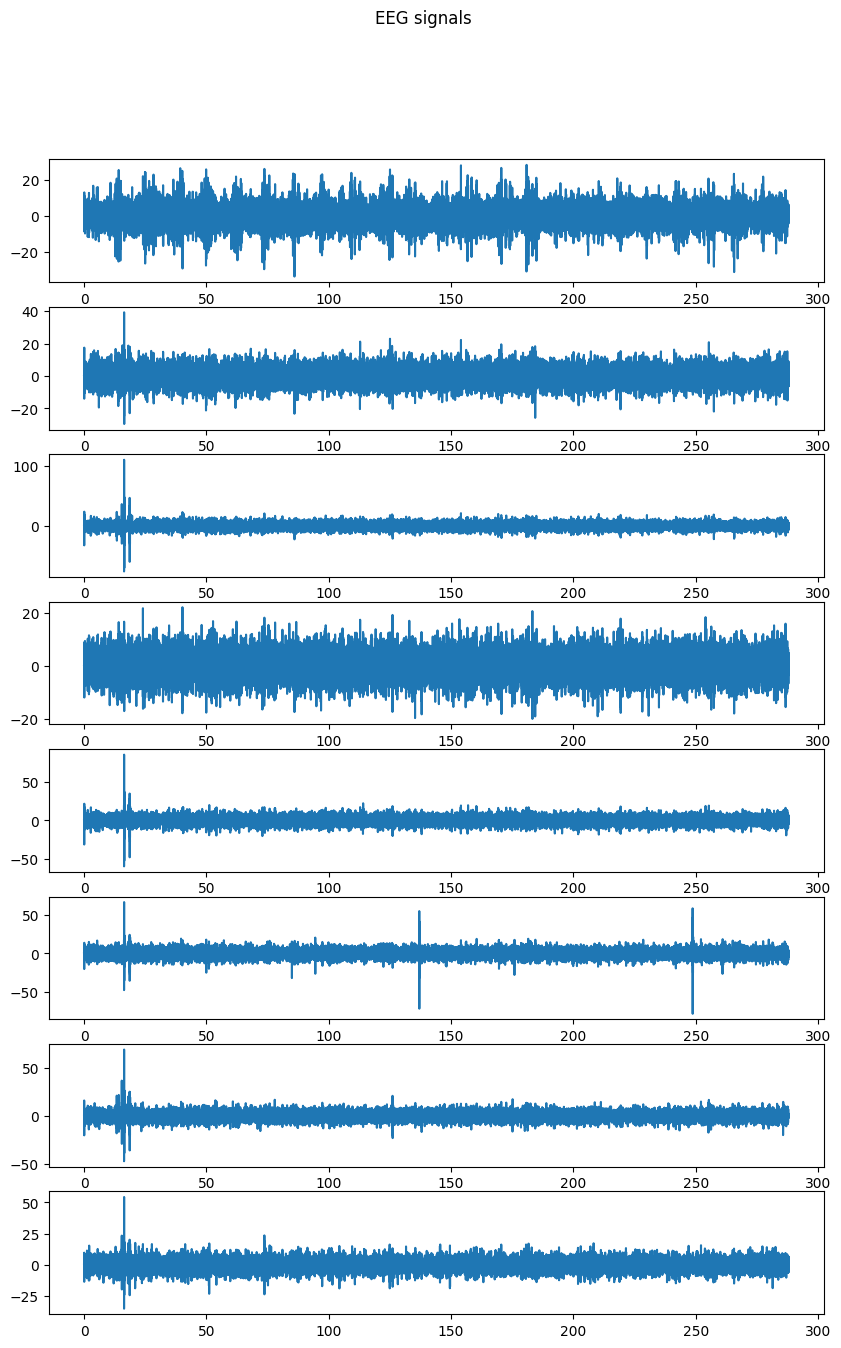

In [27]:
x1 = np.linspace(0, end/fs, end, endpoint=True)

fig, axs = plt.subplots(8, figsize=(10 , 15))
fig.suptitle('EEG signals')
for i in range(8):
    axs[i].plot(x1,df_filt1[:,i])

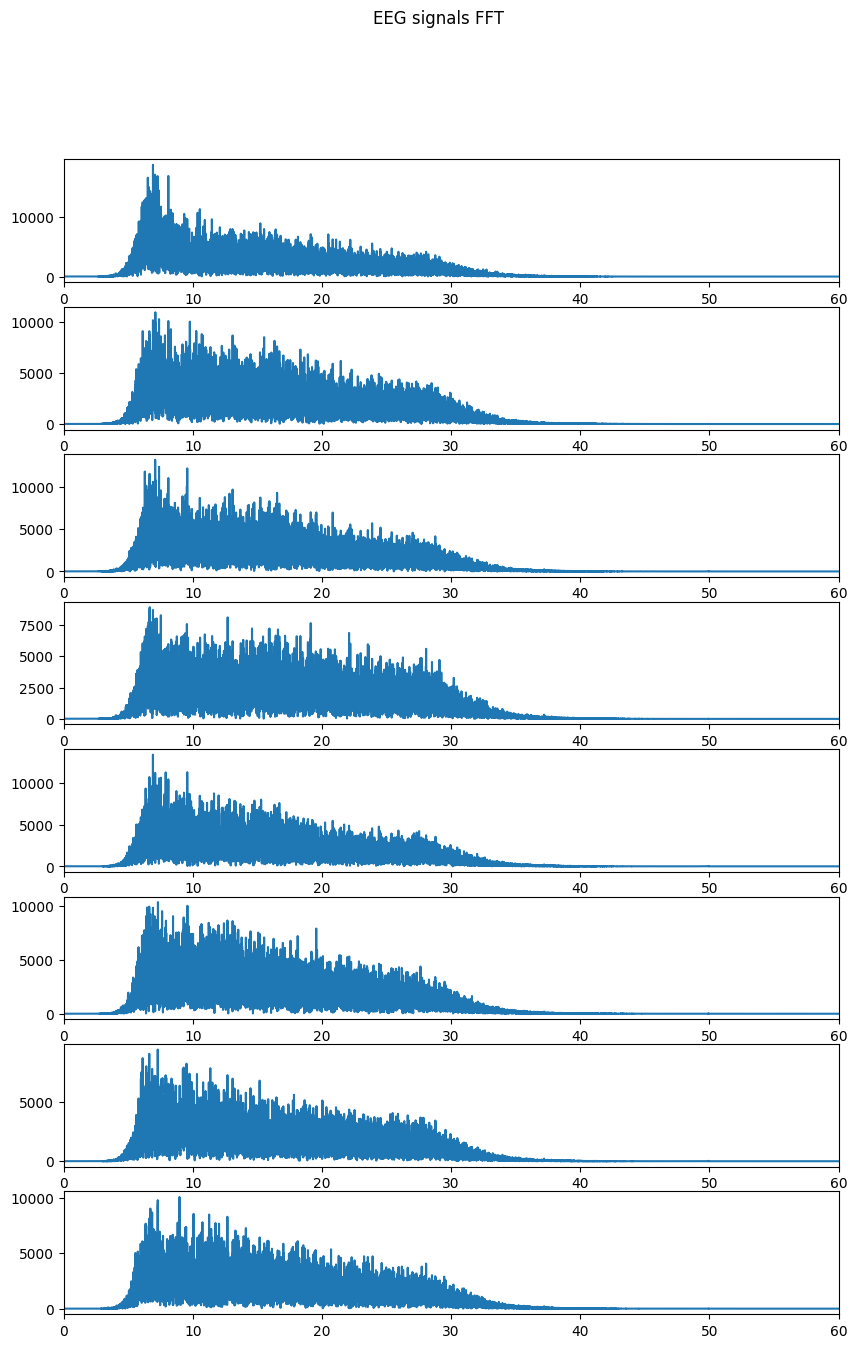

In [28]:
xf = rfftfreq(end, 1 / fs)

fig, axs = plt.subplots(8, figsize=(10 , 15))
fig.suptitle('EEG signals FFT')
for i in range(8):
    yf = rfft(df_filt1[:,i])
    axs[i].plot(xf, np.abs(yf))
    axs[i].set_xlim([0, 60])
    # Setting the number of ticks 
    axs[i].locator_params(axis='x', nbins=10)
    

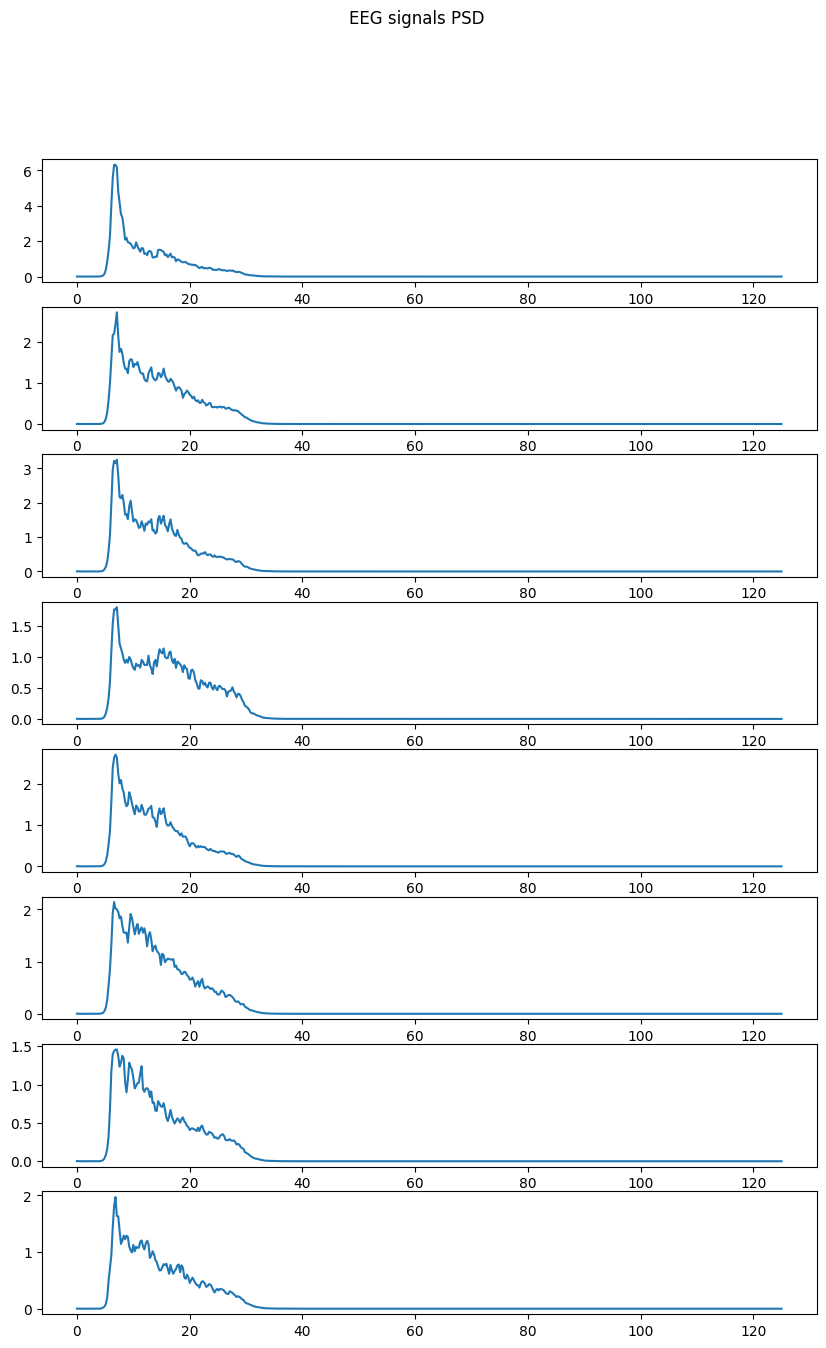

In [29]:
from scipy import signal

xf = rfftfreq(end, 1 / fs)

fig, axs = plt.subplots(8, figsize=(10 , 15))
fig.suptitle('EEG signals PSD')
for i in range(8):
    # Compute the power spectral density
    frequencies, power_density = signal.welch(df_filt1[:,i], fs, nperseg=1024, scaling='density')


    # Plot the power spectral density
    axs[i].plot(frequencies, power_density)
    #plt.psd(df[:,i], Fs = 250)
    #axs[i].xlabel('Frequency (Hz)')
    #axs[i].ylabel('Power Spectral Density')
    #axs[i].title('Power Spectral Density Plot')


